In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
train = pd.read_csv("train.csv", delimiter=",")
test = pd.read_csv("test.csv", delimiter=",")

In [3]:
print(train)

        id  sentiment                                              tweet
0     1126          0  You just got GIF bombed #AfricansInSF #BeyondG...
1     1127          1  She didn't even notice me in the background I'...
2     1128          1  70 years ago today the United States of Americ...
3     1129          1  Storm in RI worse than last hurricane. My city...
4     1130          0                    A wasp just dive bombed my face
...    ...        ...                                                ...
5544  7560          1  Two giant cranes holding a bridge collapse int...
5545  7561          1  @aria_ahrary @TheTawniest The out of control w...
5546  7562          1  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
5547  7563          1  Police investigating after an e-bike collided ...
5548  7564          1  The Latest: More Homes Razed by Northern Calif...

[5549 rows x 3 columns]


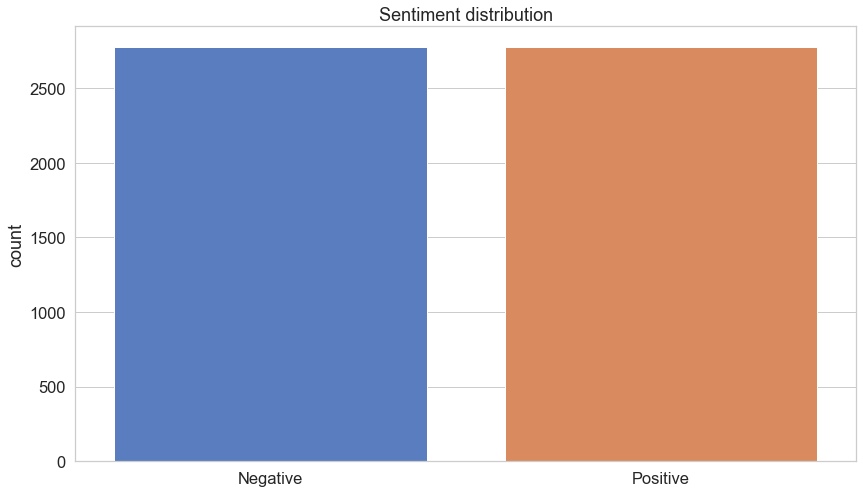

In [4]:
f = sns.countplot(x="sentiment", data=train)
label = ['Negative', 'Positive']
f.set_title("Sentiment distribution")
f.set_xticklabels(label)
plt.xlabel("");

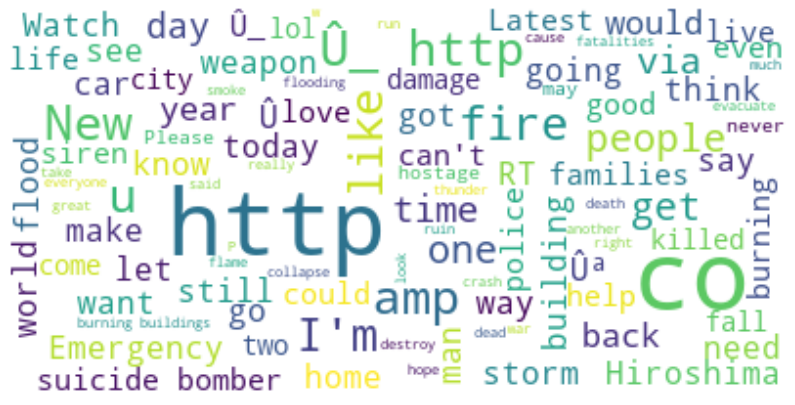

In [5]:
text = " ".join(tweet for tweet in train.tweet)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [6]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [7]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [8]:
X = train['tweet'].values
y = train['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [9]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

d:\Programs\Anaconda\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [10]:
y_hat = MNB.predict(X_test)

In [11]:
accuracy_score(y_test, y_hat)

0.6360360360360361

In [12]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       559
           1       0.62      0.68      0.65       551

    accuracy                           0.64      1110
   macro avg       0.64      0.64      0.64      1110
weighted avg       0.64      0.64      0.64      1110



In [13]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[334, 225],
       [179, 372]], dtype=int64)

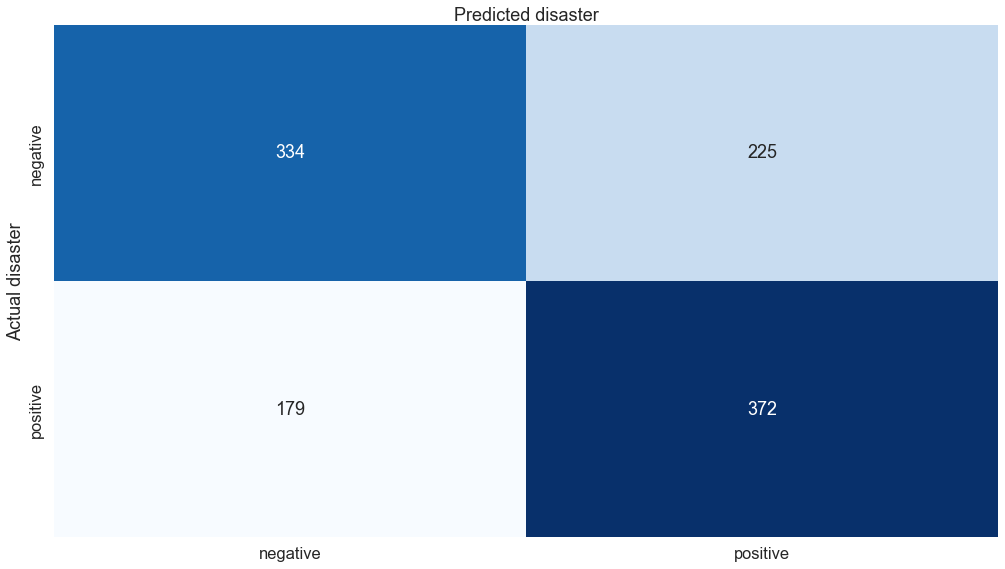

In [14]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual disaster')
plt.xlabel('Predicted disaster');